# <p style="background-color:#FFE67C;font-family:fantasy;color:#295F2D;font-size:150%;text-align:center;border-radius:20px 40px;">U.S. PATENT PHRASE TO PHRASE MATCHING</p>

<h1 align='center'>Introduction 📝</h1>
The aim of this competition is to predict the similarity of the pairs of phrases which is an anchor and a target phrase on a scale from 0 (not at all similar) to 1 (identical in meaning) within a patent's context.

##  <font color="red"> Please consider upvoting the kernel if you find it useful.</font>

このコンペティションの目的は、特許の文脈の中で、アンカーフレーズとターゲットフレーズのペアの類似性を0（全く似ていない）から1（意味が同じ）のスケールで予測することです。

<a id='1'></a>

# <p style="background-color:#FFE67C;font-family:fantasy;color:#295F2D;font-size:150%;text-align:center;border-radius:20px 40px;">IMPORTING LIBRARIES</p>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/My Drive/colab_data/USPatentPhrasetoPhraseMatch/input')

In [3]:
# for colab
%%capture
!pip install transformers

In [4]:
import os
import gc
import random
import requests
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from PIL import Image
from tqdm import tqdm
from scipy import stats
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoConfig, AutoModel, get_linear_schedule_with_warmup

import warnings
warnings.simplefilter('ignore')

In [5]:
from torch.nn import functional as F

In [6]:
class CONFIG:
    seed=2022
    num_fold = 5
    model = 'anferico/bert-for-patents'
    max_len1 = 134  # paddingの設定、これを超えた長さの文章は打ち切られる
    max_len2 = 134  # paddingの設定、これを超えた長さの文章は打ち切られる
    train_batch_size = 16  # もとは16
    valid_batch_size = 16
    epochs = 20  # 3. 2->10に変更
    learning_rate = 1e-2  # もとは1e-5 1e-3とか入れるとnanになりがち?
    scheduler = 'linear'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # iters_to_accumulate = 8  # 勾配累積させて、まとめて処理する

# BERTにはいろいろな事前学習モデルがある。
# 今回は、そのうちの一つ、anferico/bert-for-patentsというものを用いる
# TODO: このモデルをいろいろ変えたときの予測精度を比較する
# TODO: こいつを変えた複数の結果に対し、アンサンブルしてみる
CONFIG.tokenizer = AutoTokenizer.from_pretrained(CONFIG.model)

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(CONFIG.seed)

<a id='2'></a>

# <p style="background-color:#FFE67C;font-family:fantasy;color:#295F2D;font-size:150%;text-align:center;border-radius:20px 40px;">READING THE DATA</p>

In [8]:
train = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/train.csv')
test = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/test.csv')
sub = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/sample_submission.csv')

In [9]:
train.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


<a id='3'></a>
# <p style="background-color:#FFE67C;font-family:fantasy;color:#295F2D;font-size:150%;text-align:center;border-radius:20px 40px;">EXPLORATORY DATA ANALYSIS</p>

<a id='3.1'></a>
    
## 1. Score

Number of Rows having a score of 0 - 7471
Number of Rows having score greater than 0 - 29002


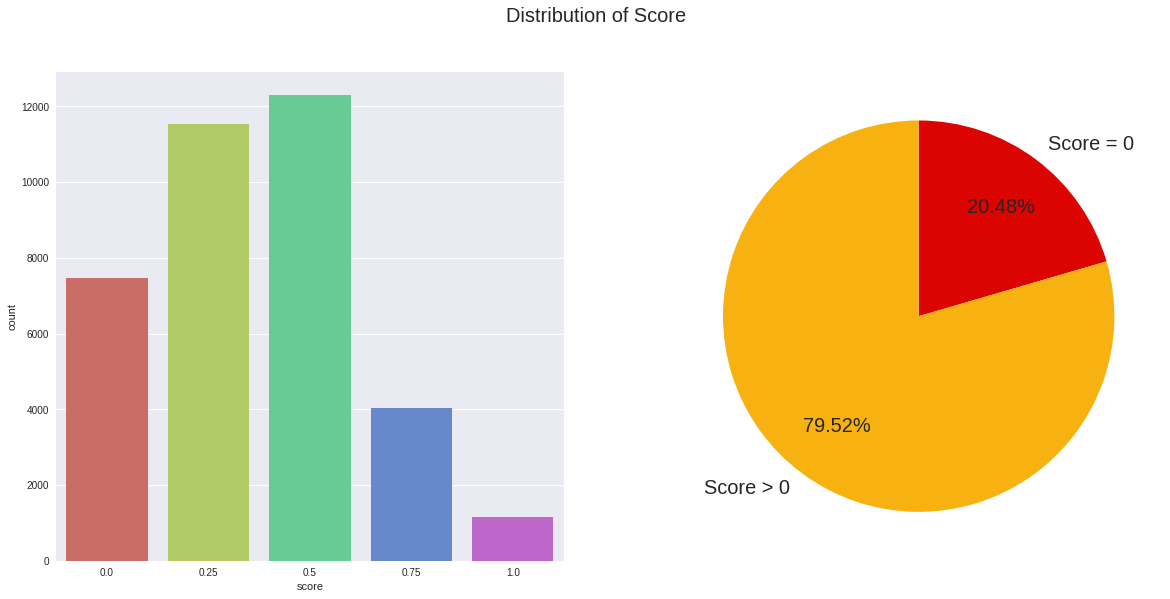

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Distribution of Score', size=20)

sns.countplot(x='score', data=train, palette='hls', ax=ax[0])

sizes = []
no_annotations = len(train[train['score']==0])
sizes.append(no_annotations)
annotated = len(train[train['score']!=0])
sizes.append(annotated)

print('Number of Rows having a score of 0 -', no_annotations)
print('Number of Rows having score greater than 0 -', annotated)

labels = ['Score = 0', 'Score > 0']
colors = ['#db0400', '#f7b211']
ax[1].pie(sizes, colors=colors, startangle=90, labels=labels,
        autopct='%.2f%%', pctdistance=0.7,textprops={'fontsize':20}, counterclock=False)

plt.show()

<a id='3.2'></a>
## 2. Anchor

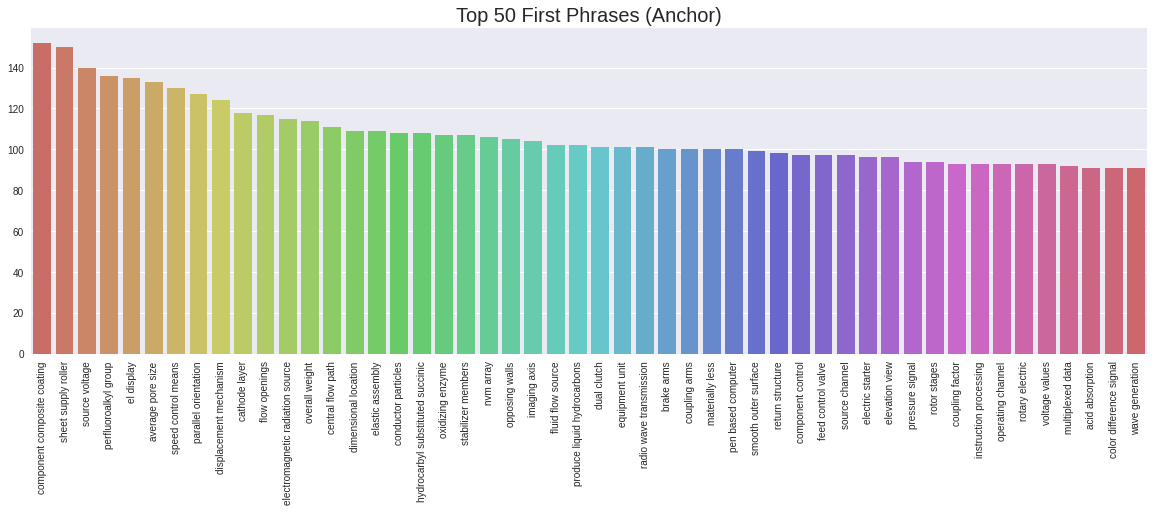

In [12]:
top = Counter([anc for anc in train['anchor']])

top = dict(top.most_common(50))

plt.figure(figsize=(20, 6))

sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
plt.xticks(rotation=90)
plt.title("Top 50 First Phrases (Anchor)", fontsize=20)

plt.show()

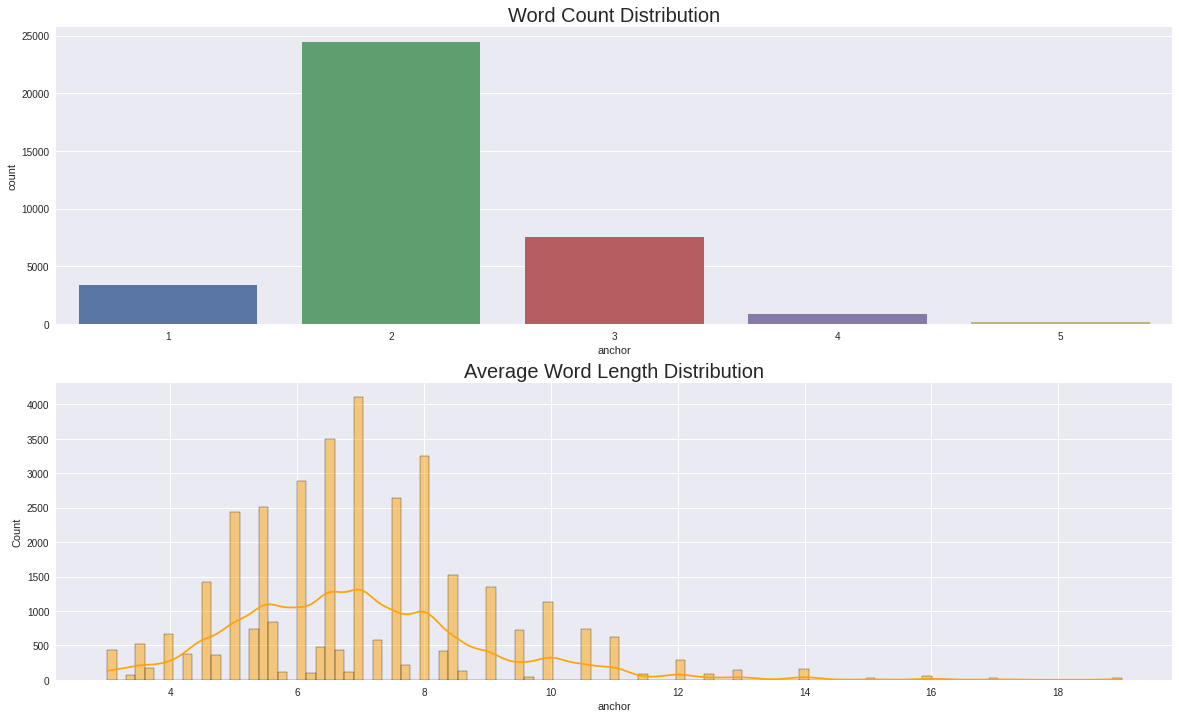

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

text_len = train['anchor'].str.split().map(lambda x : len(x))

sns.countplot(text_len, ax=ax[0])
ax[0].set_title("Word Count Distribution", size=20)

avg_word_len = train['anchor'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
sns.histplot(avg_word_len, ax=ax[1], kde=True, color='#ffa408')
ax[1].set_title('Average Word Length Distribution', size=20)

plt.show()

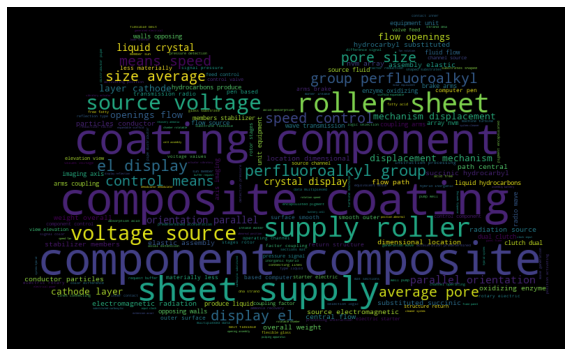

In [14]:
plt.figure(figsize=(10, 10))
text = train['anchor'].values
url = 'https://static.vecteezy.com/system/resources/previews/000/263/280/non_2x/vector-open-book.jpg'
im = np.array(Image.open(requests.get(url, stream=True).raw))
cloud = WordCloud(stopwords = STOPWORDS,
                  background_color='black',
                  mask = im,
                  max_words = 200,
                  ).generate(" ".join(text))
plt.imshow(cloud)
plt.axis('off')
plt.show()

<a id='3.3'></a>
## 3. Target

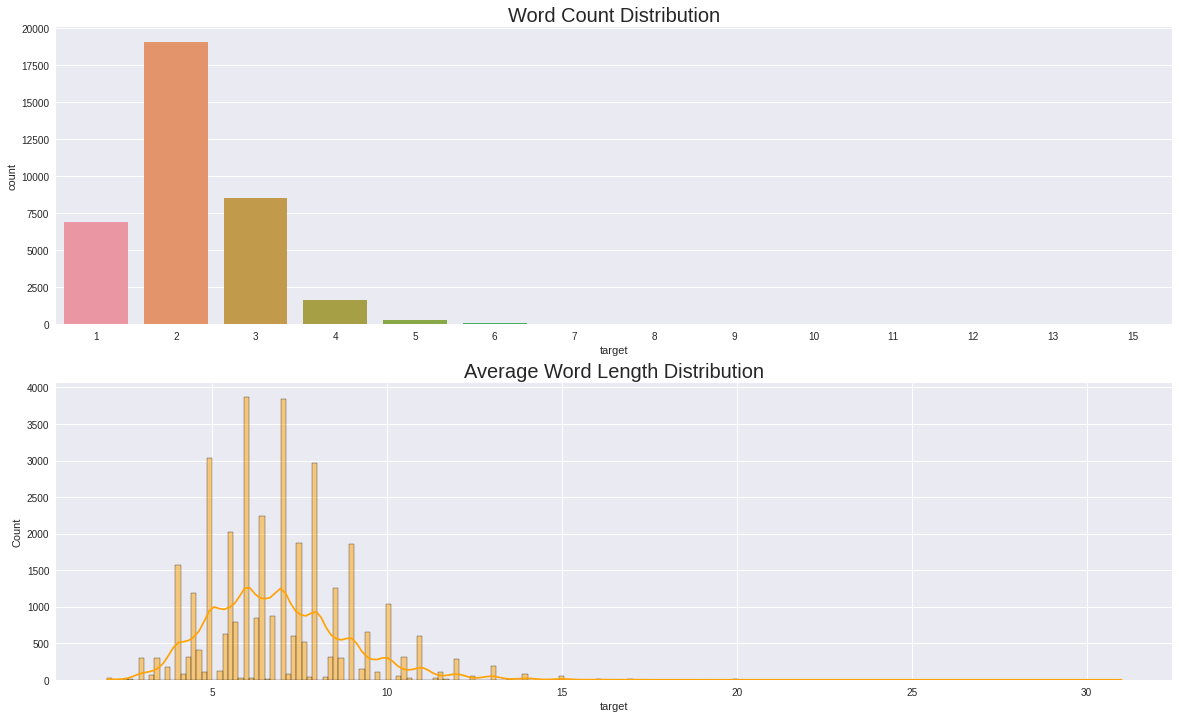

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

text_len = train['target'].str.split().map(lambda x : len(x))

sns.countplot(text_len, ax=ax[0])
ax[0].set_title("Word Count Distribution", size=20)

avg_word_len = train['target'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
sns.histplot(avg_word_len, ax=ax[1], kde=True, color='#ffa408')
ax[1].set_title('Average Word Length Distribution', size=20)

plt.show()

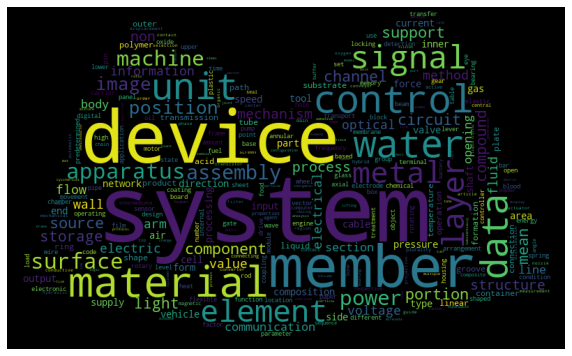

In [16]:
plt.figure(figsize=(10, 10))
text = train['target'].values
url = 'https://static.vecteezy.com/system/resources/previews/000/263/280/non_2x/vector-open-book.jpg'
im = np.array(Image.open(requests.get(url, stream=True).raw))
cloud = WordCloud(stopwords = STOPWORDS,
                  background_color='black',
                  mask = im,
                  max_words = 300,
                  ).generate(" ".join(text))
plt.imshow(cloud)
plt.axis('off')
plt.show()

<a id='3.4'></a>
## 4. Context

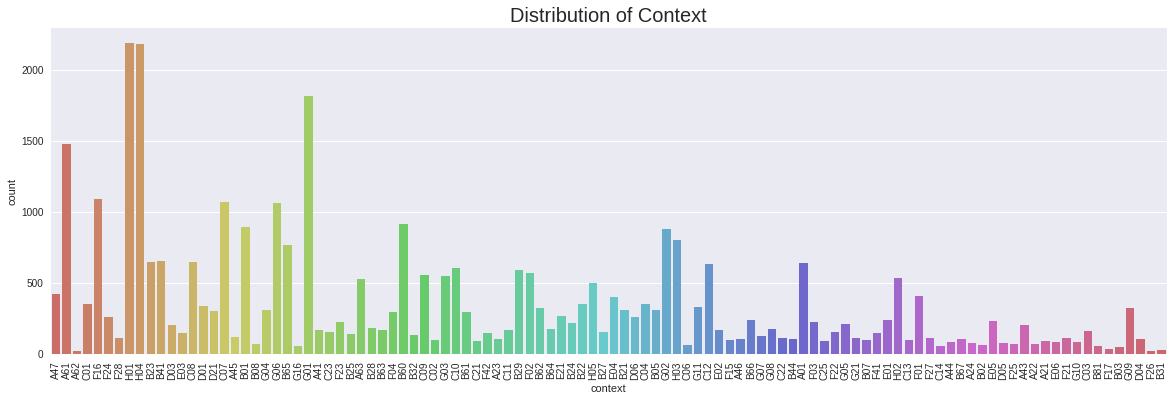

In [17]:
plt.figure(figsize=(20, 6))

sns.countplot(x='context', data=train, palette='hls')
plt.xticks(rotation=90)
plt.title("Distribution of Context", fontsize=20)

plt.show()

The first letter is the "section symbol" consisting of a letter from "A" ("Human Necessities") to "H" ("Electricity") or "Y" for emerging cross-sectional technologies. This is followed by a two-digit number to give a "class symbol" ("A01" represents "Agriculture; forestry; animal husbandry; trapping; fishing").

* A: Human Necessities
* B: Operations and Transport
* C: Chemistry and Metallurgy
* D: Textiles
* E: Fixed Constructions
* F: Mechanical Engineering
* G: Physics
* H: Electricity
* Y: Emerging Cross-Sectional Technologies

In [18]:
train['section'] = train['context'].astype(str).str[0]
train['classes'] = train['context'].astype(str).str[1:]

In [19]:
# TODO: このA - とかいうのを取ってみる
# TODO: こいつを学習データに突っ込んでみる
sections = {"A" : "Human Necessities", 
            "B" : "Operations and Transport",
            "C" : "Chemistry and Metallurgy",
            "D" : "Textiles",
            "E" : "Fixed Constructions",
            "F" : "Mechanical Engineering",
            "G" : "Physics",
            "H" : "Electricity",
            "Y" : "Emerging Cross-Sectional Technologies"}

<a id='3.5'></a>
## 5. CPC-Code Description
Additional Data - https://www.kaggle.com/datasets/xhlulu/cpc-codes

In [20]:
df_cpc = pd.read_csv('../input/cpc-codes/titles.csv')
df_cpc.head(5)

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,1.0,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,1.0,B,1.0,2.0


In [21]:
# 小分類を追加
train['title'] = train['context'].map(df_cpc.set_index('code')['title']).str.lower()
test['title'] = test['context'].map(df_cpc.set_index('code')['title']).str.lower()

In [22]:
# 大分類を追加
train['section'] = train['context'].map(df_cpc.set_index('code')['section']).str.upper()
test['section'] = test['context'].map(df_cpc.set_index('code')['section']).str.upper()
train['section'] = train['section'].map(sections).str.lower()
test['section'] = test['section'].map(sections).str.lower()

In [23]:
# https://www.kaggle.com/code/himanshubag/fine-tuning-bert-simple-and-straightforward
def clean(x):
    t = x.lower()
    t = t.replace("[",'')
    t = t.replace(";",'')
    t = t.replace(",",'')
    t = t.replace("]",'')
    t = t.replace(":",'')
    return t

train['title'] = train['title'].apply(lambda x: clean(x))
train.head()
test['title'] = test['title'].apply(lambda x: clean(x))

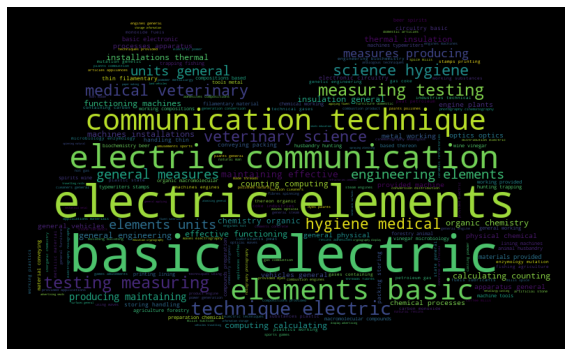

In [24]:
plt.figure(figsize=(10, 10))
text = train['title'].values
url = 'https://static.vecteezy.com/system/resources/previews/000/263/280/non_2x/vector-open-book.jpg'
im = np.array(Image.open(requests.get(url, stream=True).raw))
cloud = WordCloud(stopwords = STOPWORDS,
                  background_color='black',
                  mask = im,
                  max_words = 200,
                  ).generate(" ".join(text))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [25]:
# 12. あまりに長いtitleは、sectionに差し替える
def long_title_convert(title, section):
    token = CONFIG.tokenizer(title, section)
    if len(token.input_ids) >= 20:
        return section
    else:
        return title

In [26]:
train['title'] = train.apply(lambda x: long_title_convert(x['title'], x['section']), axis=1)
test['title'] = test.apply(lambda x: long_title_convert(x['title'], x['section']), axis=1)

In [27]:
# train['text'] = '[CLS] ' + train['anchor'] + ' [SEP] [CLS] ' + train['target'] + ' [SEP] ' + train['title']
# test['text'] = '[CLS] ' + test['anchor'] + ' [SEP] [CLS] ' + test['target'] + ' [SEP]  ' + test['title']
# 12. titleを2ついれてみる
train['text'] = '[CLS] ' + train['anchor'] + ' of ' + train['title'] +  ' [SEP] ' + train['target'] + ' of' + train['title']
test['text'] = '[CLS] ' + test['anchor'] + ' of ' + test['title'] +  ' [SEP] ' + test['target'] + ' of' + test['title']

In [28]:
CONFIG.max_len1 = -1
CONFIG.max_len2 = -1
arr = []
for text in train.text:
    token = CONFIG.tokenizer(text)
    arr.append(len(token.input_ids))
arr = np.array(arr)
CONFIG.max_len1 = int(np.quantile(arr, 1))

arr = []
for text in train.title:
    token = CONFIG.tokenizer(text)
    arr.append(len(token.input_ids))
arr = np.array(arr)
CONFIG.max_len2 = int(np.quantile(arr, 1))
print(CONFIG.max_len1, CONFIG.max_len2)

64 15


<a id='4'></a>

# <p style="background-color:#FFE67C;font-family:fantasy;color:#295F2D;font-size:150%;text-align:center;border-radius:20px 40px;">CREATE FOLDS</p>

In [29]:
encoder = LabelEncoder()
train['score_encoded'] = encoder.fit_transform(train['score'])

skf = StratifiedKFold(n_splits=CONFIG.num_fold, shuffle=True, random_state=CONFIG.seed)

for k, (_, val_ind) in enumerate(skf.split(X=train, y=train['score_encoded'])):
    train.loc[val_ind, 'fold'] = k

<a id='5'></a>

# <p style="background-color:#FFE67C;font-family:fantasy;color:#295F2D;font-size:150%;text-align:center;border-radius:20px 40px;">DATASET CLASS</p>

In [30]:
class USPatentDataset(Dataset):
    def __init__(self, df):
        self.score = df['score']
        self.text = df['text']
        self.title = df['title']
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = self.text[index]
        title = self.title[index]
        score = self.score[index]

        # https://note.com/npaka/n/n36acd2122192
        # 2つの文を2つの引数として与えることで、文のペアをエンコードできる
        # 整数列が返ってくる
        # inputs = CONFIG.tokenizer(anchor, target, padding='max_length', max_length=CONFIG.max_len, truncation=True)
        inputs1 = CONFIG.tokenizer(text, padding='max_length', max_length=CONFIG.max_len1, truncation=True)
        inputs2 = CONFIG.tokenizer(title, padding='max_length', max_length=CONFIG.max_len2, truncation=True)

        # TODO: titleもここに追加したい
        # TODO: A-何とかから始まるやつらもここに追加したい
        # TODO: 単語の長さとかも追加したい。
        # https://dajiro.com/entry/2020/06/27/160255
        return {
            "ids1": torch.tensor(inputs1["input_ids"], dtype=torch.long),
            "mask1": torch.tensor(inputs1["attention_mask"], dtype=torch.long),
            "token_type_ids1": torch.tensor(inputs1["token_type_ids"], dtype=torch.long),
            "ids2": torch.tensor(inputs2["input_ids"], dtype=torch.long),
            "mask2": torch.tensor(inputs2["attention_mask"], dtype=torch.long),
            "token_type_ids2": torch.tensor(inputs2["token_type_ids"], dtype=torch.long),
            "label": torch.tensor(score, dtype=torch.float),
        }

<a id='6'></a>

# <p style="background-color:#FFE67C;font-family:fantasy;color:#295F2D;font-size:150%;text-align:center;border-radius:20px 40px;">BASELINE MODEL</p>

In [31]:
class USPatentModel(nn.Module):
    def __init__(self):
        super(USPatentModel, self).__init__()
        
        config = AutoConfig.from_pretrained(CONFIG.model)

        self.bert1 = AutoModel.from_pretrained(CONFIG.model, config=config)
        # self.bert2 = AutoModel.from_pretrained(CONFIG.model, config=config)
        # hidden_sizeは1024
        # self.bn1 = nn.BatchNorm1d(config.hidden_size, momentum=0.01)
        # self.fc2 = nn.Linear(config.hidden_size, 64)
        # self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(config.hidden_size, 1)
        
    def forward(self, input1, input2):
        # TODO: bertの戻り値を調べる。
        # bertは、input_ids, attention_mask, labelsを引数として与える
        # bertの戻り値は
        # [0]は、各トークンを埋め込んだもの
        # [1]は、pooler_outputらしい
        # <https://qiita.com/masahikoofjoyto/items/f4a7e95a747b9b64b91d>
        # last_hidden_state, pooler_output, hidden_states, attentionsを返しているようだ
        # pooler_outputは、文章の平均値のようなものらしい。
        x = self.bert1(*input1).pooler_output
        # x2 = self.bert2(*input2).pooler_output
        # x2 = self.bert1(*input2).pooler_output  # bertを2つ使うとおっそいので、使いまわしてみる。
        # x = torch.cat((x1, x2), 1)
        # x = F.silu(self.bn1(x))
        # x = F.silu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        # x += 0.5
        
        return x

In [32]:
class Model1(nn.Module):
    def __init__(self):
        super(USPatentModel, self).__init__()
        
        config = AutoConfig.from_pretrained(CONFIG.model)

        self.bert1 = AutoModel.from_pretrained(CONFIG.model, config=config)
        # self.bert2 = AutoModel.from_pretrained(CONFIG.model, config=config)
        # hidden_sizeは1024
        self.bn1 = nn.BatchNorm1d(config.hidden_size, momentum=0.01)
        self.fc2 = nn.Linear(config.hidden_size, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, input1, input2):
        x = self.bert1(*input1).pooler_output
        x = F.silu(self.bn1(x))
        x = F.silu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        
        return x

<a id='7'></a>

# <p style="background-color:#FFE67C;font-family:fantasy;color:#295F2D;font-size:150%;text-align:center;border-radius:20px 40px;">UTILITY FUNCTIONS</p>

In [33]:
# Function to get data according to the folds
def get_data(fold):
    train_df = train[train['fold'] != fold].reset_index(drop=True)
    valid_df = train[train['fold'] == fold].reset_index(drop=True)
    
    train_dataset = USPatentDataset(train_df)
    valid_dataset = USPatentDataset(valid_df)
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, shuffle=False)
    
    return train_loader, valid_loader

def loss_fn(outputs, labels):
    return nn.MSELoss()(outputs, labels)

def compute_pearson(outputs, labels):
    # スコア計算用に、相関係数を計算する
    # Squash values between 0 to 1
    outputs[outputs < 0] = 0
    outputs[outputs > 1] = 1
    
    # Round off to nearest 0.25 factor
    outputs = 0.25 * np.round(outputs/0.25) 
    
    pearsonr = stats.pearsonr(outputs, labels)[0]
    return pearsonr

def compute_pearson_no_round(outputs, labels):
    # スコア計算用に、相関係数を計算する
    # Squash values between 0 to 1
    outputs[outputs < 0] = 0
    outputs[outputs > 1] = 1
    
    # Round off to nearest 0.25 factor
    # 5 * np.round(outputs/0.25) 
    
    pearsonr = stats.pearsonr(outputs, labels)[0]
    return pearsonr

def get_optimizer(model):
    # 自作レイヤとBERT部分で学習率を変える
    # BERTに高い学習率を入れると、モデルが壊れる
    # BERTくん「ち、チノちゃん！learning_rate高くしないで！」
    # チノ「うるさいですね…」 learning_rate = 1
    # BERTくん「あ、あぁ～ッ！」 *破壊的忘却*

    param_optimizer = list(model.named_parameters())
    model_type = ['bert']
    no_decay = ["bias", "LayerNorm.weight"]
    local_layer = ['bn', 'fc']

    local_param = [p for n, p in param_optimizer if any(name in n for name in local_layer)]
    bert_param = [(n, p) for n, p in param_optimizer if any(name in n for name in model_type)]
    no_decay_param = [p for n, p in bert_param if any(name in n for name in no_decay)]
    decay_param = [p for n, p in bert_param if not any(name in n for name in no_decay)]
    if len(local_param) == 0 or len(bert_param) == 0 or len(no_decay_param) == 0 or len(decay_param) == 0:
        print('optimizer errer', len(local_param), len(bert_param), len(no_decay_param), len(decay_param))
        raise 'optimizer errer'
    optimizer_parameters = [
        {
            # bn?とfc?についての設定
            "params": local_param,
            "weight_decay": 0.01,
            "lr" : CONFIG.learning_rate
        },
        { 
            # bertについての設定_no_decay分
            "params": no_decay_param,
            "weight_decay": 0.0,
            "lr" : 1e-5
        },
        { 
            # bertについての設定_decay分
            "params": decay_param,
            "weight_decay": 0.01,
            "lr" : 1e-5
        },
    ]

    optimizer = AdamW(optimizer_parameters)

    return optimizer

def get_scheduler(cfg, optimizer, train_loader):
    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            # TODO これ算式あってる・・・？
            num_warmup_steps=int((len(train_loader)*CONFIG.epochs*6)/100),
            num_training_steps=CONFIG.epochs*len(train_loader),
        )
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int((len(train_loader)*CONFIG.epochs*6)/100),
            num_training_steps=CONFIG.epochs*len(train_loader),
        )
    return scheduler

In [34]:
for p in USPatentModel().named_parameters():
    print(p[0])
    break  # delete for check all params

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert1.embeddings.word_embeddings.weight


In [35]:
from collections import OrderedDict
from collections import deque
from statistics import mean

In [36]:
def train_fn(model, data_loader, optimizer, scheduler, device, epoch):
    # 1epoch分の処理
    model.train()  # modelの振る舞いが変わる、batch_normのオンオフ的な感じらしい
    
    running_loss = 0
    mv_running_loss = 0
    preds = []
    label=[]
    progress_bar = tqdm(data_loader, position=0)
    loss_que = deque()
    
    for step, data in enumerate(progress_bar):
        ids1 = data['ids1'].to(device)
        masks1 = data['mask1'].to(device)
        token_type_ids1 = data['token_type_ids1'].to(device)

        ids2 = data['ids2'].to(device)
        masks2 = data['mask2'].to(device)
        token_type_ids2 = data['token_type_ids2'].to(device)

        labels = data['label'].to(device)

        input1 = (ids1, masks1, token_type_ids1)
        input2 = (ids2, masks2, token_type_ids2)

        outputs = model(input1, input2)
        loss = loss_fn(outputs.view(-1, 1), labels.view(-1, 1))
        
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
        
        running_loss += loss.item()
        mv_running_loss += loss.item()
        loss_que.append(loss.item())
        while len(loss_que) >= 100:
            rm = loss_que.popleft()
            mv_running_loss -= rm
        
        preds.extend(outputs.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        progress_bar.set_description(f"Epoch [{epoch+1}/{CONFIG.epochs}]")
        progress_bar.set_postfix(OrderedDict(loss=running_loss/(step+1), mvloss=mv_running_loss/len(loss_que)))
    
    train_pearson = compute_pearson(np.array(preds), np.array(label))
    train_pearson2 = compute_pearson_no_round(np.array(preds), np.array(label))
    
    return train_pearson, train_pearson2

def valid_fn(model, data_loader, device, epoch):
    # 1epoch分の処理
    # TODO: with torch.no_grad():を足してみる
    model.eval()
    
    running_loss = 0
    preds = []
    label = []
    progress_bar = tqdm(data_loader, position=0)
    
    for step, data in enumerate(progress_bar):
        ids1 = data['ids1'].to(device)
        masks1 = data['mask1'].to(device)
        token_type_ids1 = data['token_type_ids1'].to(device)

        ids2 = data['ids2'].to(device)
        masks2 = data['mask2'].to(device)
        token_type_ids2 = data['token_type_ids2'].to(device)

        labels = data['label'].to(device)

        input1 = (ids1, masks1, token_type_ids1)
        input2 = (ids2, masks2, token_type_ids2)

        with torch.no_grad():
            outputs = model(input1, input2)

        loss = loss_fn(outputs.view(-1, 1), labels.view(-1, 1))

        running_loss += loss.item()

        preds.extend(outputs.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())

        progress_bar.set_description(f"Epoch [{epoch+1}/{CONFIG.epochs}]")
        progress_bar.set_postfix(loss=running_loss/(step+1))
    
    valid_pearsonr = compute_pearson(np.array(preds), np.array(label))
    valid_pearsonr2 = compute_pearson_no_round(np.array(preds), np.array(label))
    
    return valid_pearsonr, valid_pearsonr2

In [37]:
def run(fold):
    train_loader, valid_loader = get_data(fold)
    
    # ここでモデルの初期化をかけている
    # アンサンブルのために使うモデルを切り替えたいなら、ここをいじる
    # 量子化の効果はほとんどなし。
    # https://nmoriyama.hatenablog.com/entry/2020/04/10/161254

    model = USPatentModel().to(CONFIG.device)

    optimizer = get_optimizer(model)
    
    scheduler = get_scheduler(CONFIG, optimizer, train_loader)
    
    best_valid_pearson = 0
    for epoch in range(CONFIG.epochs):
        train_pearson, train_pearson2 = train_fn(model, train_loader, optimizer, scheduler, CONFIG.device, epoch)
        valid_pearson, valid_pearson2 = valid_fn(model, valid_loader, CONFIG.device, epoch)
        print(f"Train Pearson Coeff - {train_pearson}, Valid Pearson Coeff - {valid_pearson}")
        print(f"Train Pearson Coeff - {train_pearson2}, Valid Pearson Coeff - {valid_pearson2}")
        if valid_pearson > best_valid_pearson:
            print(f"Validation F1 Improved - {best_valid_pearson} ---> {valid_pearson}")
            torch.save(model.state_dict(), f'./model_{fold}.bin')
            print(f"Saved model checkpoint at ./model_{fold}.bin")
            best_valid_pearson = valid_pearson
    
    return best_valid_pearson

<a id='8'></a>

# <p style="background-color:#FFE67C;font-family:fantasy;color:#295F2D;font-size:150%;text-align:center;border-radius:20px 40px;">TRAINING</p>

In [ ]:
for fold in range(CONFIG.num_fold):
    print("=" * 30)
    print("Training Fold - ", fold)
    print("=" * 30)
    best_valid_pearson = run(fold)
    print(f'Best Pearson Correlation Coefficient: {best_valid_pearson:.5f}')
    
    gc.collect()
    torch.cuda.empty_cache()    
    break # To run for all the folds, just remove this break

Training Fold -  0


Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch [1/20]: 100%|██████████| 456/456 [00:56<00:00,  8.10it/s, loss=0.0472]


Train Pearson Coeff - 0.4451819378144912, Valid Pearson Coeff - 0.7151582388060873
Train Pearson Coeff - 0.4715865439092014, Valid Pearson Coeff - 0.7686076394902703
Validation F1 Improved - 0 ---> 0.7151582388060873
Saved model checkpoint at ./model_0.bin


Epoch [2/20]:   8%|▊         | 148/1824 [01:00<11:16,  2.48it/s, loss=0.0352, mvloss=0.0348]

## memo

ここからいろいろ書き換えていく
<https://www.kaggle.com/code/utcarshagrawal/usppm-complete-eda-pytorch-baseline>

Lossの目安は0.025以下、可能なら0.022程度

1. default: 0.7964476441271049
2. レイヤーを変更:0.72992->10foldで0.81945
3. titleを追加(VRAMがやばい、レイヤーのサイズを小さくしたり、バッチサイズを小さくしたりして調整すること。）->0.82529
4. [SEP]っての使ってみる、合わせて、titleがtest側について調整できてなかったので修正。加え、max_lenを75%タイル点に修正
  * 量子化は効果なし<https://nmoriyama.hatenablog.com/entry/2020/04/10/161254>
  * スコアが悪化したので、titleを除外。->効果なし。後で足しなおす
  * 勾配累積が悪さしているかもなので、外してみる->いったんOK?
  * titleを追加-> 1epoch30分。。。
5. max_lenの設定が単語数ではなく文字数だった不具合を修正
5. titleを別のbertに突っ込んでみる。titleに結果が引きずられている気がするので。 1epoch50分。。。 これをやる場合とやらない場合でスコアを比較する。
  * あまりに遅いので、同じbertを使いまわしてみる。
  * [CLS]を入れてみる regresserだから今回はいらないのかもだけど
5. とりあえず雑にlrを1e-3くらいに挙げてみる->なんか大変なことになった・・・
  * lrを戻した
5. たぶん初期解が0に対し、最小二乗誤差がうまく機能できないっぽい。ラベルを-0.5ずらしてみる->無意味だった
5. レイヤー層を追加してみる。bert使いまわししているので、効果あるかも->スコア0
5. いったん、textだけのモデルに戻す->機能する
5. titleを入れるとこわれる->[CLS]が3つあるとこわれるみたい->0.82225
5. clean wordをやる<https://www.kaggle.com/code/himanshubag/fine-tuning-bert-simple-and-straightforward>
5. titleを2つ入れてみる？->0.83494
5. [CLS]を1つにしてみる->0.83110
  * 下がったけど誤差？それとも有意な差？
  * これをModel1とする
5. 余分なレイヤー層を取ってみる
5. 無理ぽ・・・ここにあるモデルから改変していくことにする<https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train/notebook>
5. ある程度予測できるようになったら、カスタム損失関数を入れる。0.5とか、あいまいな場合を高く評価する

6. TODO: Deberta_V3っての使ってみる<https://www.kaggle.com/code/vikazrajpurohit/deberta-v3-large-transformer-head>
7. TODO: Convolution?っていうのがあるらしい<https://www.ai-shift.co.jp/techblog/2145>。こいつらに対してアンサンブルしてみたい